In [1]:
import os
os.chdir('../')

In [2]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random

from main import parse_args_and_config, Diffusion
from datasets import inverse_data_transform

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.benchmark = False

###############################################################################
# 1) Notebook에서 sys.argv를 직접 설정 (argparse 흉내)
###############################################################################
sys.argv = [
    "main.py",
    "--config", "imagenet64.yml",  # 사용하려는 config
    "--sample",
    "--sample_type", "lagrangesolver",
    "--dpm_solver_type", "data_prediction",
    "--dpm_solver_order", "1",
    "--timesteps", "120",
    "--skip_type", "logSNR",
    "--ni"
]

###############################################################################
# 2) 인자/설정 로드
###############################################################################
args, config = parse_args_and_config()

###############################################################################
# 3) Diffusion 객체 생성 -> 모델 로딩
###############################################################################
diffusion = Diffusion(args, config, rank=0)
diffusion.prepare_model()
diffusion.model.eval()

###############################################################################
# 4) 배치(25장) 한 번에 샘플링 -> 5x5 그리드(여백 없이) 시각화
###############################################################################
device = diffusion.device

INFO - main.py - 2025-03-27 07:51:05,215 - Using device: cuda


[prepare_model] Loading ckpt from /data/checkpoints/dpm-solver/imagenet64_uncond_100M_1500K.pt ...
[prepare_model] Checkpoint loaded.
[prepare_model] Model is ready.


In [3]:
from tqdm import tqdm

def sample_in_batches(diffusion, config, device, total_samples=1024, batch_size=16):
    pairs = []
    for i in tqdm(range(0, total_samples, batch_size)):
        bs = min(batch_size, total_samples - i)
        noise = np.random.randn(bs, config.data.channels, config.data.image_size, config.data.image_size).astype(np.float32)
        noise = torch.tensor(noise, device=device)
        data, _ = diffusion.sample_image(noise, diffusion.model)
        pair = torch.stack([noise, data], dim=1)
        pairs.append(pair)
    return torch.cat(pairs, dim=0)

pairs = sample_in_batches(diffusion, config, device, total_samples=256, batch_size=16)
print(pairs.shape)

100%|██████████| 16/16 [01:00<00:00,  3.76s/it]

torch.Size([256, 2, 3, 64, 64])


In [4]:
!mkdir -p optimization/pair
save_file = 'optimization/pair/euler_NFE=120_N=256.pt'
torch.save(pairs.data.cpu(), save_file)
pairs_load = torch.load(save_file)
pairs_load.shape

torch.Size([256, 2, 3, 64, 64])

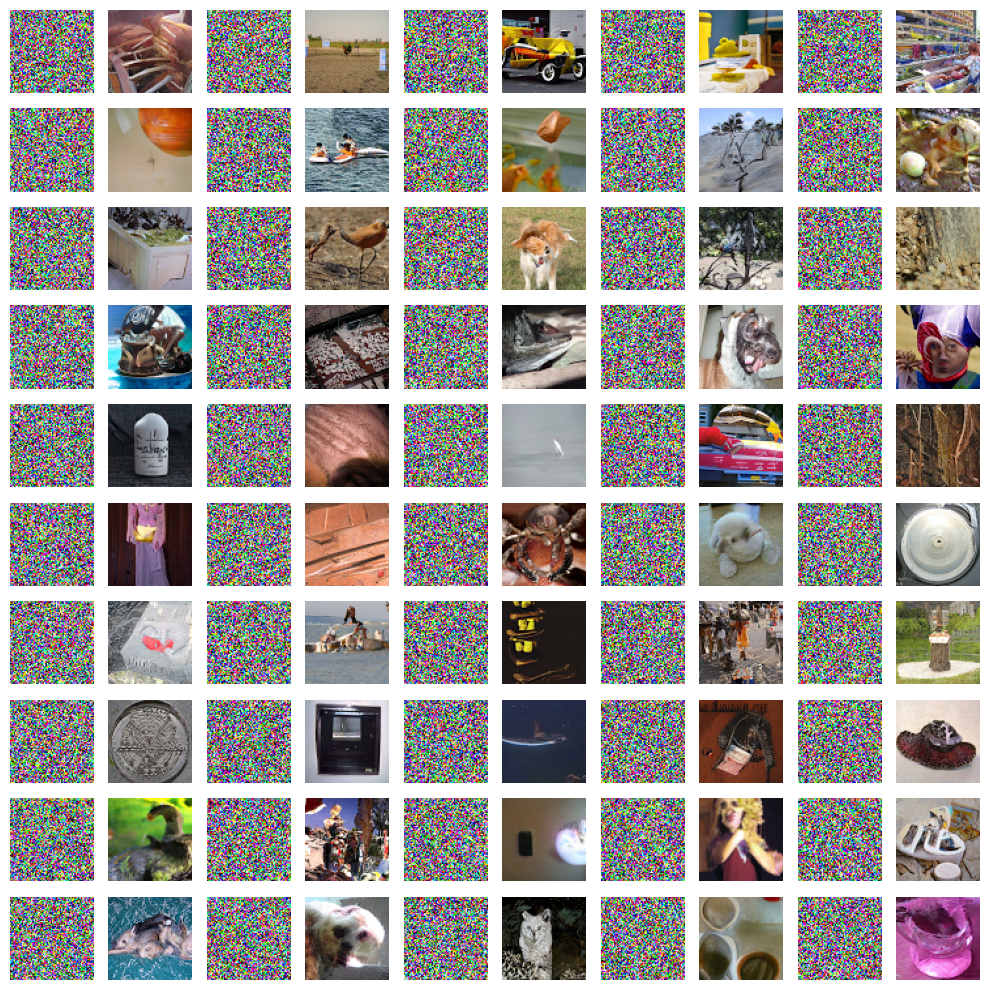

In [5]:
# 2. noise([:, 0])와 image([:, 1]) 각 50쌍(총 100장) 사용
pairs = pairs_load[:50]  # shape: [50, 2, 3, 64, 64]

# 3. 10×10 서브플롯(= 100개 칸) 생성
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))

# 4. 50쌍을 10×10에 배치
#    - 한 줄당 5쌍(즉 10장) → 10줄이면 총 50쌍
for i in range(50):
    # 행(r)과 열(c)을 계산
    r = i // 5              # 0 ~ 9
    c = (i % 5) * 2         # 짝수 열(0, 2, 4, 6, 8)
    
    # (1) noise ([:, 0]) 표시
    noise = inverse_data_transform(config, pairs[i, 0]).permute(1, 2, 0).cpu().numpy()  # (3,H,W) → (H,W,3)
    axes[r, c].imshow(noise)
    axes[r, c].axis('off')
    
    # (2) image ([:, 1]) 표시
    img = inverse_data_transform(config, pairs[i, 1]).permute(1, 2, 0).cpu().numpy()
    axes[r, c+1].imshow(img)
    axes[r, c+1].axis('off')

plt.tight_layout()
plt.show()

In [6]:
pairs_load[:, 1, 0, 0]

tensor([[-0.0268, -0.0448, -0.0117,  ..., -0.2564, -0.3624, -0.3295],
        [ 0.3267,  0.3405,  0.3587,  ...,  0.3893,  0.3858,  0.3760],
        [-0.8941, -0.8979, -0.8872,  ..., -0.1090, -0.0992,  0.0239],
        ...,
        [-0.5895, -0.5844, -0.5970,  ..., -0.6058, -0.6103, -0.6034],
        [-0.5466,  0.0706, -0.4598,  ...,  0.0243,  0.0224, -0.0021],
        [ 0.9874,  0.9919,  0.9956,  ...,  0.9944,  0.9932,  0.9931]])